# RFA-based NN growth experiment (WIP)
# TODO

In [1]:
import ipycanvas

training_canvas, ranks_canvas, input_domain_canvas = ipycanvas.Canvas(), ipycanvas.Canvas(), ipycanvas.Canvas()
training_canvas.width = training_canvas.height = 1000
ranks_canvas.width, ranks_canvas.height = 1200, 600
input_domain_canvas.width = input_domain_canvas.height = 600
training_canvas.font = ranks_canvas.font = input_domain_canvas.font = "30px arial"
args = ('Results will appear as processed', training_canvas.width / 4, training_canvas.height / 3)
training_canvas.fill_text(*args); ranks_canvas.fill_text(*args); input_domain_canvas.fill_text(*args)

In [2]:
training_canvas

Canvas(height=1000, width=1000)

In [3]:
ranks_canvas

Canvas(height=600, width=1200)

In [4]:
input_domain_canvas

Canvas(height=600, width=600)

In [5]:
from experiment import execute_experiment
from plots import plot_effective_rank_and_detected_noise_on_canvas, plot_samples_and_model_activation_on_canvas

experiment_results = execute_experiment(
    seed=12345,
    noise_rate=0.,
    within_cluster_variance=1. / 25.,
    input_dimension=2,
    sample_size=5000,
    batch_size=5000,
    epochs=1000,
    learning_rate=0.05,
    hidden_units=100,
    initialization_variance=1 / (32. * 500.),
    runs_per_model=1,
    clusters_per_class=2,
    convergence_epsilon=0.1,
    save_models_path='./models/',
    save_experiments_path='./experiments/',
    saving_epochs_interval=100
)

Train accuracy: 0.9991999864578247


(-1.0, 1.0)

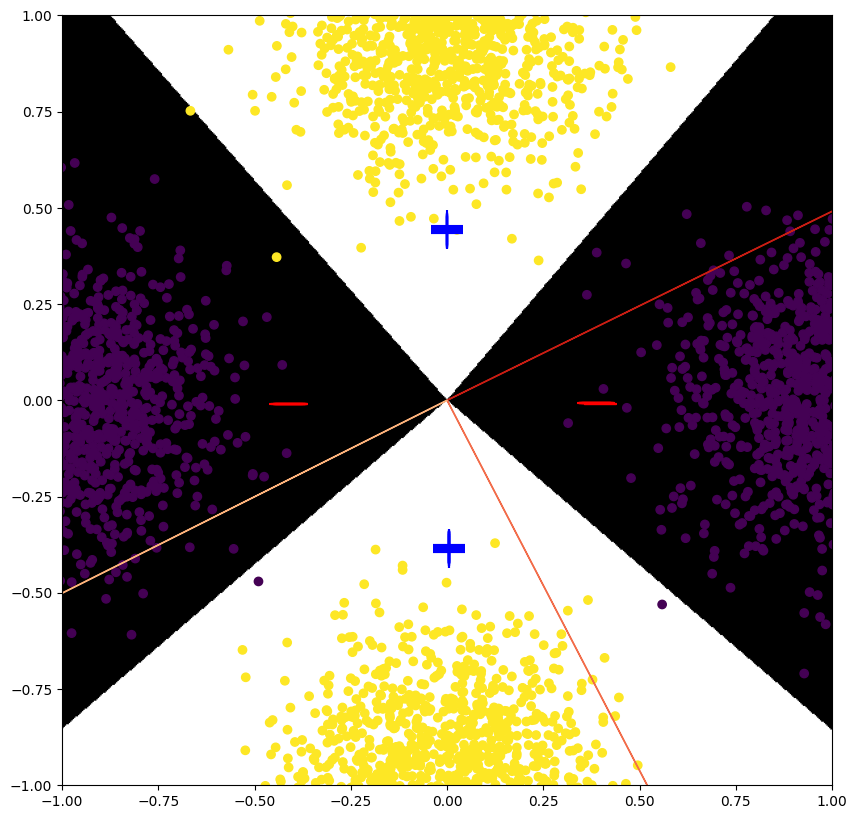

In [1]:
experiment_results = dict(
    seed=12345,
    noise_rate=0.,
    within_cluster_variance=1. / 25.,
    input_dimension=2,
    sample_size=5000,
    batch_size=5000,
    epochs=1000,
    learning_rate=0.05,
    hidden_units=100,
    initialization_variance=1 / (32. * 500.),
    runs_per_model=1,
    clusters_per_class=2,
    convergence_epsilon=0.1,
    save_models_path='./models/',
    save_experiments_path='./experiments/',
    saving_epochs_interval=100,
    run=0
)

import numpy, torch, matplotlib.cm

from experiment import TwoLayerNeuralNet
from settings.noisy_xor import get_dataloader
from utils.optimization import Accuracy, initialize
from utils.plotting import plot_samples_and_model_activation

initialize(experiment_results['seed'])

data, rotation_matrix = get_dataloader(**experiment_results)
_, (inputs, labels) = next(enumerate(data))

model = TwoLayerNeuralNet.load('./models/', **experiment_results)
predictions = model(torch.concatenate([inputs, labels], dim=1))
print(f'Train accuracy: {Accuracy(predictions, labels)}')

fig = plot_samples_and_model_activation(data, model, rotation_matrix, experiment_results['input_dimension'])
[ax] = fig.axes

loss = torch.nn.BCEWithLogitsLoss()(predictions, labels)
loss.backward()

outer_product_d_L_d_sigma = model.dummy_variable1.grad.detach().cpu().numpy()
eigvals, eigvecs = numpy.linalg.eig(outer_product_d_L_d_sigma)
eigvals = abs(eigvals.real)
eigvecs = numpy.array(list(map(lambda x: x[1], sorted(zip(eigvals, eigvecs.real.transpose()), key=lambda x: x[0], reverse=True))))
eigvals = sorted(eigvals, reverse=True)
r_k = [sum(eigvals[k:]) / eigenvalue for k, eigenvalue in enumerate(eigvals[:-1]) if eigenvalue > 0][:-1]
k_star = r_k.index(min(r_k))

eigvecs_weights = numpy.matmul(eigvecs, model.input_layer.weight.data.detach().cpu().numpy())
#eigvecs_biases = numpy.matmul(eigvecs, model.input_layer.bias.data.detach().cpu().numpy()).tolist()
colors = matplotlib.cm.OrRd_r(numpy.linspace(.2, .6, k_star))
for eigenvector, color in zip(eigvecs_weights, colors):
    ax.arrow(0, 0, *eigenvector, color=color)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

In [2]:
def gradients_summary(model, *args, summary={}, epoch_frequency=100):
    epoch = len(summary.get('train', []))
    if epoch % epoch_frequency != 0: return
    outer_product_d_L_d_sigma = model.dummy_variable1.grad.detach().cpu().numpy()
    eigenvalues = sorted(numpy.abs(numpy.linalg.eigvals(outer_product_d_L_d_sigma).real).tolist(), reverse=True)
    r_k = [sum(eigenvalues[k:]) / eigenvalue for k, eigenvalue in enumerate(eigenvalues[:-1]) if eigenvalue > 0][:-1]
    summary['r_k_d_L_d_sigma'] = summary.get('r_k_d_L_d_sigma', []) + [r_k]
    summary['eigenspectrum_d_L_d_sigma'] = summary.get('eigenspectrum_d_L_d_sigma', []) + [eigenvalues]

    outer_product_sigma = model.activations.t().mm(model.activations).detach().cpu().numpy()
    eigenvalues = sorted(numpy.abs(numpy.linalg.eigvals(outer_product_sigma).real).tolist(), reverse=True)
    r_k = [sum(eigenvalues[k:]) / eigenvalue for k, eigenvalue in enumerate(eigenvalues[:-1]) if eigenvalue > 0][:-1]
    summary['r_k_sigma'] = summary.get('r_k_sigma', []) + [r_k]
    summary['eigenspectrum_sigma'] = summary.get('eigenspectrum_sigma', []) + [eigenvalues]
    
run = {}
gradients_summary(model, summary=run)

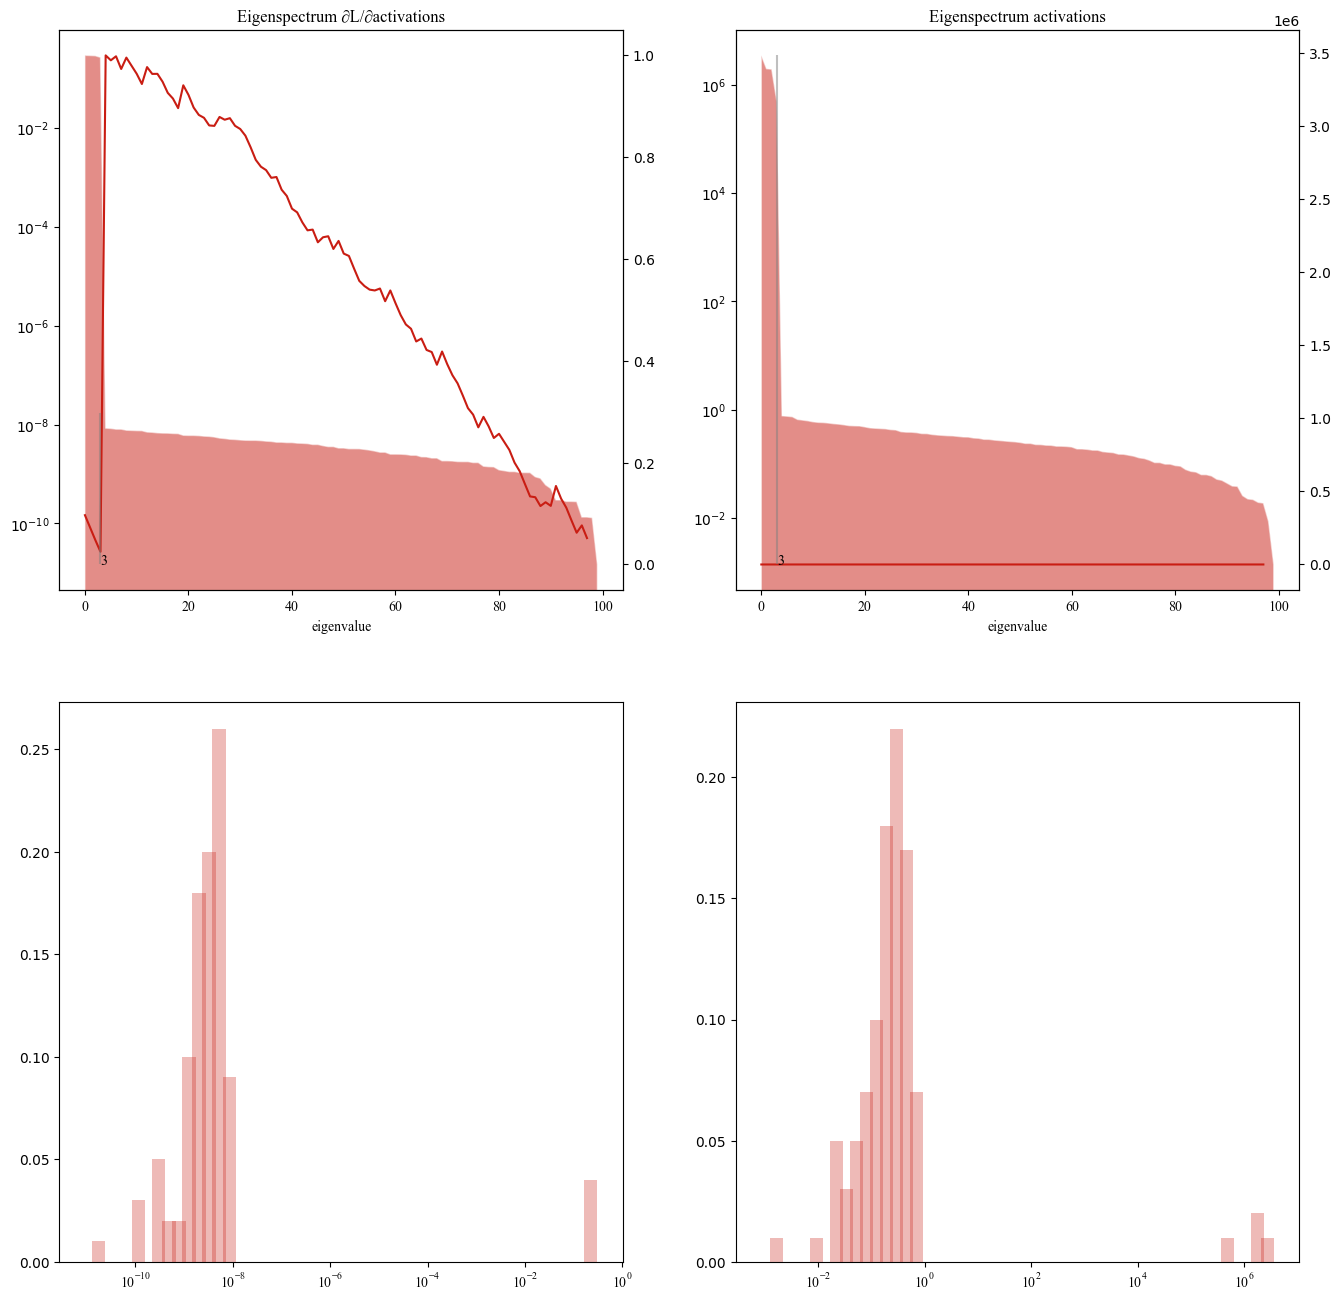

In [3]:
"""Implements plots for the effective_rank-based growth experiment."""

import os, sys, functools, numpy, torch, matplotlib.pyplot, matplotlib.cm

sys.path.append(os.path.abspath(os.path.join('..')))  # Allow repository modules to be imported

from utils.plotting import draw_figure_into_canvas

FONT = 'Times New Roman'
HISTOGRAM_BINS = 50

def _plot_eigenspectrum_and_effective_rank(eigenspectrum, effective_ranks, iteration, area_color, eigenspectrum_ax, effective_rank_ax):
    num_eigenvalues = len(eigenspectrum)
    k_star = effective_ranks.index(min(effective_ranks))
    eigenspectrum = numpy.array(eigenspectrum)
    effective_ranks = numpy.array(effective_ranks) / max(effective_ranks)
    eigenspectrum_ax.fill_between(list(range(num_eigenvalues)), [- iteration / 2,] * num_eigenvalues, eigenspectrum - iteration / 2, 
                        facecolor=area_color, edgecolor='w', alpha=0.5)
    effective_rank_ax.plot(list(range(len(effective_ranks))), effective_ranks - iteration / 2, c=area_color)
    effective_rank_ax.vlines(k_star, - iteration / 2, max(eigenspectrum) - iteration / 2, colors='grey', alpha=0.5)
    effective_rank_ax.text(k_star, - iteration / 2, f'{k_star:.0f}', fontdict={'family': FONT})

def histogram_bars(histogram_frequencies, histogram_bins):
    histogram_bins_pace = histogram_bins[1] - histogram_bins[0]
    histogram_bins += histogram_bins_pace / 2.
    return histogram_bins, histogram_frequencies / histogram_frequencies.sum(), histogram_bins_pace

def _plot_eigenspectrum_distribution(eigenspectrum, iteration, area_color, eigenspectrum_distribution_ax, 
                                     histogram_bins=HISTOGRAM_BINS, eigenspectrum_distribution_log_scale=True):
    eigenspectrum = numpy.array(eigenspectrum)
    if eigenspectrum_distribution_log_scale:
        zero_eigenvalues = eigenspectrum[eigenspectrum==0]
        nonzero_eigenvalues = eigenspectrum[eigenspectrum!=0]
        bins, frequency, _ = histogram_bars(*numpy.histogram(numpy.log(nonzero_eigenvalues), bins=histogram_bins))
        bins = numpy.concatenate([numpy.array([0]), numpy.exp(bins)])
        frequency = numpy.concatenate([numpy.array([len(zero_eigenvalues) / float(len(eigenspectrum))]), frequency])
        width = numpy.diff(bins)
        eigenspectrum_distribution_ax.set_xscale('log')
    else:
        bins, frequency, width = histogram_bars(*numpy.histogram(numpy.log(nonzero_eigenvalues), bins=histogram_bins))

    frequency += iteration
    eigenspectrum_distribution_ax.bar(bins[:-1], frequency, width, color=area_color, alpha=0.3)

def plot_eigenspectrum(run=None, epoch=0, epoch_frequency=10000, canvas=None, **kwargs):     
    if epoch % epoch_frequency != 0: return
    fig, ((rs_ax, rs_ax2), (eigenspectrum_distribution_ax, eigenspectrum_distribution_ax2)) = matplotlib.pyplot.subplots(2, 2, figsize=(16, 16))
    rs_ax.set_title('Eigenspectrum ∂L/∂activations', fontname=FONT)
    rs_ax.set_xlabel('eigenvalue', fontname=FONT)
    effective_rank_ax = rs_ax.twinx()
    rs_ax.set_yscale('log')
    rs_ax2.set_title('Eigenspectrum activations', fontname=FONT)
    rs_ax2.set_xlabel('eigenvalue', fontname=FONT)
    effective_rank_ax2 = rs_ax2.twinx()
    rs_ax2.set_yscale('log')

    area_colors = matplotlib.cm.OrRd_r(numpy.linspace(.2, .6, len(run['eigenspectrum_d_L_d_sigma'])))
    for iteration, (eigenspectrum_d_L_d_sigma, r_k_d_L_d_sigma, eigenspectrum_sigma, r_k_sigma, area_color) in enumerate(
            zip(run['eigenspectrum_d_L_d_sigma'], run['r_k_d_L_d_sigma'], run['eigenspectrum_sigma'], run['r_k_sigma'], area_colors
        )):
       _plot_eigenspectrum_and_effective_rank(eigenspectrum_d_L_d_sigma, r_k_d_L_d_sigma, iteration, area_color, rs_ax, effective_rank_ax)
       _plot_eigenspectrum_and_effective_rank(eigenspectrum_sigma, r_k_sigma, iteration, area_color, rs_ax2, effective_rank_ax2)
       
       _plot_eigenspectrum_distribution(eigenspectrum_d_L_d_sigma, iteration, area_color, eigenspectrum_distribution_ax)
       _plot_eigenspectrum_distribution(eigenspectrum_sigma, iteration, area_color, eigenspectrum_distribution_ax2)

    for ax in (rs_ax, rs_ax2, effective_rank_ax, effective_rank_ax2, eigenspectrum_distribution_ax, eigenspectrum_distribution_ax2): 
        for tick in ax.get_xticklabels(): tick.set_fontname(FONT)

    if canvas is not None: draw_figure_into_canvas(fig, canvas)

plot_eigenspectrum(run, 0)

In [9]:
eigvals[95]

2.7630875e-10

In [10]:
stop

NameError: name 'stop' is not defined

In [ ]:
import numpy, torch

from experiment import TwoLayerNeuralNet
from settings.noisy_xor import get_dataloader
from utils.optimization import Accuracy, initialize

initialize(experiment_results['seed'])

data, rotation_matrix = get_dataloader(**experiment_results)
_, (inputs, labels) = next(enumerate(data))

model = TwoLayerNeuralNet.load('./models/', {**experiment_results, 'run': 0})
predictions = model(torch.concatenate([inputs, labels], dim=1))
print(f'Accuracy: {Accuracy(predictions, labels)}')

loss = torch.nn.BCEWithLogitsLoss(reduction='none')(predictions, labels)

In [ ]:
input_dimension = experiment_results['input_dimension']
clusters_centers = [[1., 0.], [0., 1.], [-1., 0.], [0., -1.]]

extended_clusters_centers = numpy.concatenate([
    numpy.array(clusters_centers), 
    numpy.repeat(numpy.repeat(0., input_dimension - 2)[numpy.newaxis, :], len(clusters_centers), axis=0)
], axis=1)

extended_clusters_centers = torch.tensor(numpy.matmul(extended_clusters_centers, rotation_matrix), dtype=torch.float)

inputs_cluster = inputs.mm(extended_clusters_centers.t()).argmax(dim=1)
data = torch.concatenate([model.activations.norm(dim=1).unsqueeze(1), loss], dim=1)

In [ ]:
import matplotlib.pyplot

histogram_resolution = 20

def histogram_bars(histogram_frequencies, histogram_bins):
    histogram_bins = histogram_bins.detach().cpu().numpy()[:-1]
    histogram_bins_pace = histogram_bins[1] - histogram_bins[0]
    histogram_bins += histogram_bins_pace / 2.
    histogram_frequencies = histogram_frequencies.detach().cpu().numpy()
    return histogram_bins, histogram_frequencies / histogram_frequencies.sum(), histogram_bins_pace

fig, (activations_ax, loss_ax, scatter_ax) = matplotlib.pyplot.subplots(1, 3, figsize=(18, 6))

activations_ax.set_title('Activations')
activations_ax.set_xlabel('activation L2 norm')
activations_ax.set_ylabel('% samples')

loss_ax.set_title('Loss')
loss_ax.set_xlabel('loss norm')
loss_ax.set_ylabel('% samples')

scatter_ax.set_title('Activations vs Loss')
scatter_ax.set_xlabel('activation L2 norm')
scatter_ax.set_ylabel('loss')

for cluster_index, cluster in zip(inputs_cluster.unique().tolist(), [[1., 0.], [0., 1.], [-1., 0.], [0., -1.]]):
    activations_ax.bar(*histogram_bars(*torch.histogram(data[inputs_cluster==cluster_index][:, 0], histogram_resolution)), label=f'cluster {cluster}', alpha=0.3)
    loss_ax.bar(*histogram_bars(*torch.histogram(data[inputs_cluster==cluster_index][:, 1], histogram_resolution)), label=f'cluster {cluster}', alpha=0.3)
    scatter_ax.scatter(data[inputs_cluster==cluster_index][:, 0].detach().numpy(), data[inputs_cluster==cluster_index][:, 1].detach().numpy(), label=f'cluster {cluster}')

for ax in (activations_ax, loss_ax, scatter_ax): ax.legend()

fig